In [6]:
# !pip install transformers tokenizers -q

In [7]:
from modeling import *
from trainer import *
from dataloader import *

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Датасет

In [8]:
df = pd.read_excel('make_dataset/07042023_dataset_sort_povtor.xlsx')
df.head()

,q,a,tq,ta,nonlabel,nanlabel,label
0,"Здраствуйте, если ты уже зачислен на первый ку...",Здравствуйте. Вам необходимо сообщить об этом ...,"[45783., 33649., 733., 33980., 2993.]","[18016., 29619., 38602.]",3,2,0
1,Здравствуйте! В магистратуре можно ли поменять...,Здравствуйте. По данному вопросу обратитесь по...,"[5081., 42173., 15234., 14159.]","[70433., 33013.]",3,2,0
2,Добрый день! Абитуриент МАГ/261 ФЭН.1Мз. По со...,"Здравствуйте. Приказ уже был, информация о зач...","[27231., 17201., 42247., 17097., 40774., 43366.]","[57359., 17201., 48984., 26629., 35841., 1650.]",3,2,0
3,"Здравствуйте, как забрать оригинал аттестата, ...",Здравствуйте. Вам необходимо обратиться в прие...,"[13267., 36172., 59028., 39770., 39370.]","[18016., 29619., 32373., 33442., 30785., 34715.]",3,2,0
4,Здравствуйте. Где на сайте можно ознакомиться ...,Здравствуйте. Приказы о зачислении на сайте не...,"[5081., 37763.]","[57714., 53299.]",3,2,0


In [9]:
sorted(df.label.unique())

[0, 1, 2, 3, 4, 5, 6]

[Text(0, 0, 'поступление - перевод'),
 Text(0, 1, 'общежитие'),
 Text(0, 2, 'учебная деятельность'),
 Text(0, 3, 'внеучебная деятельность'),
 Text(0, 4, 'документы'),
 Text(0, 5, 'работа'),
 Text(0, 6, 'финансы')]

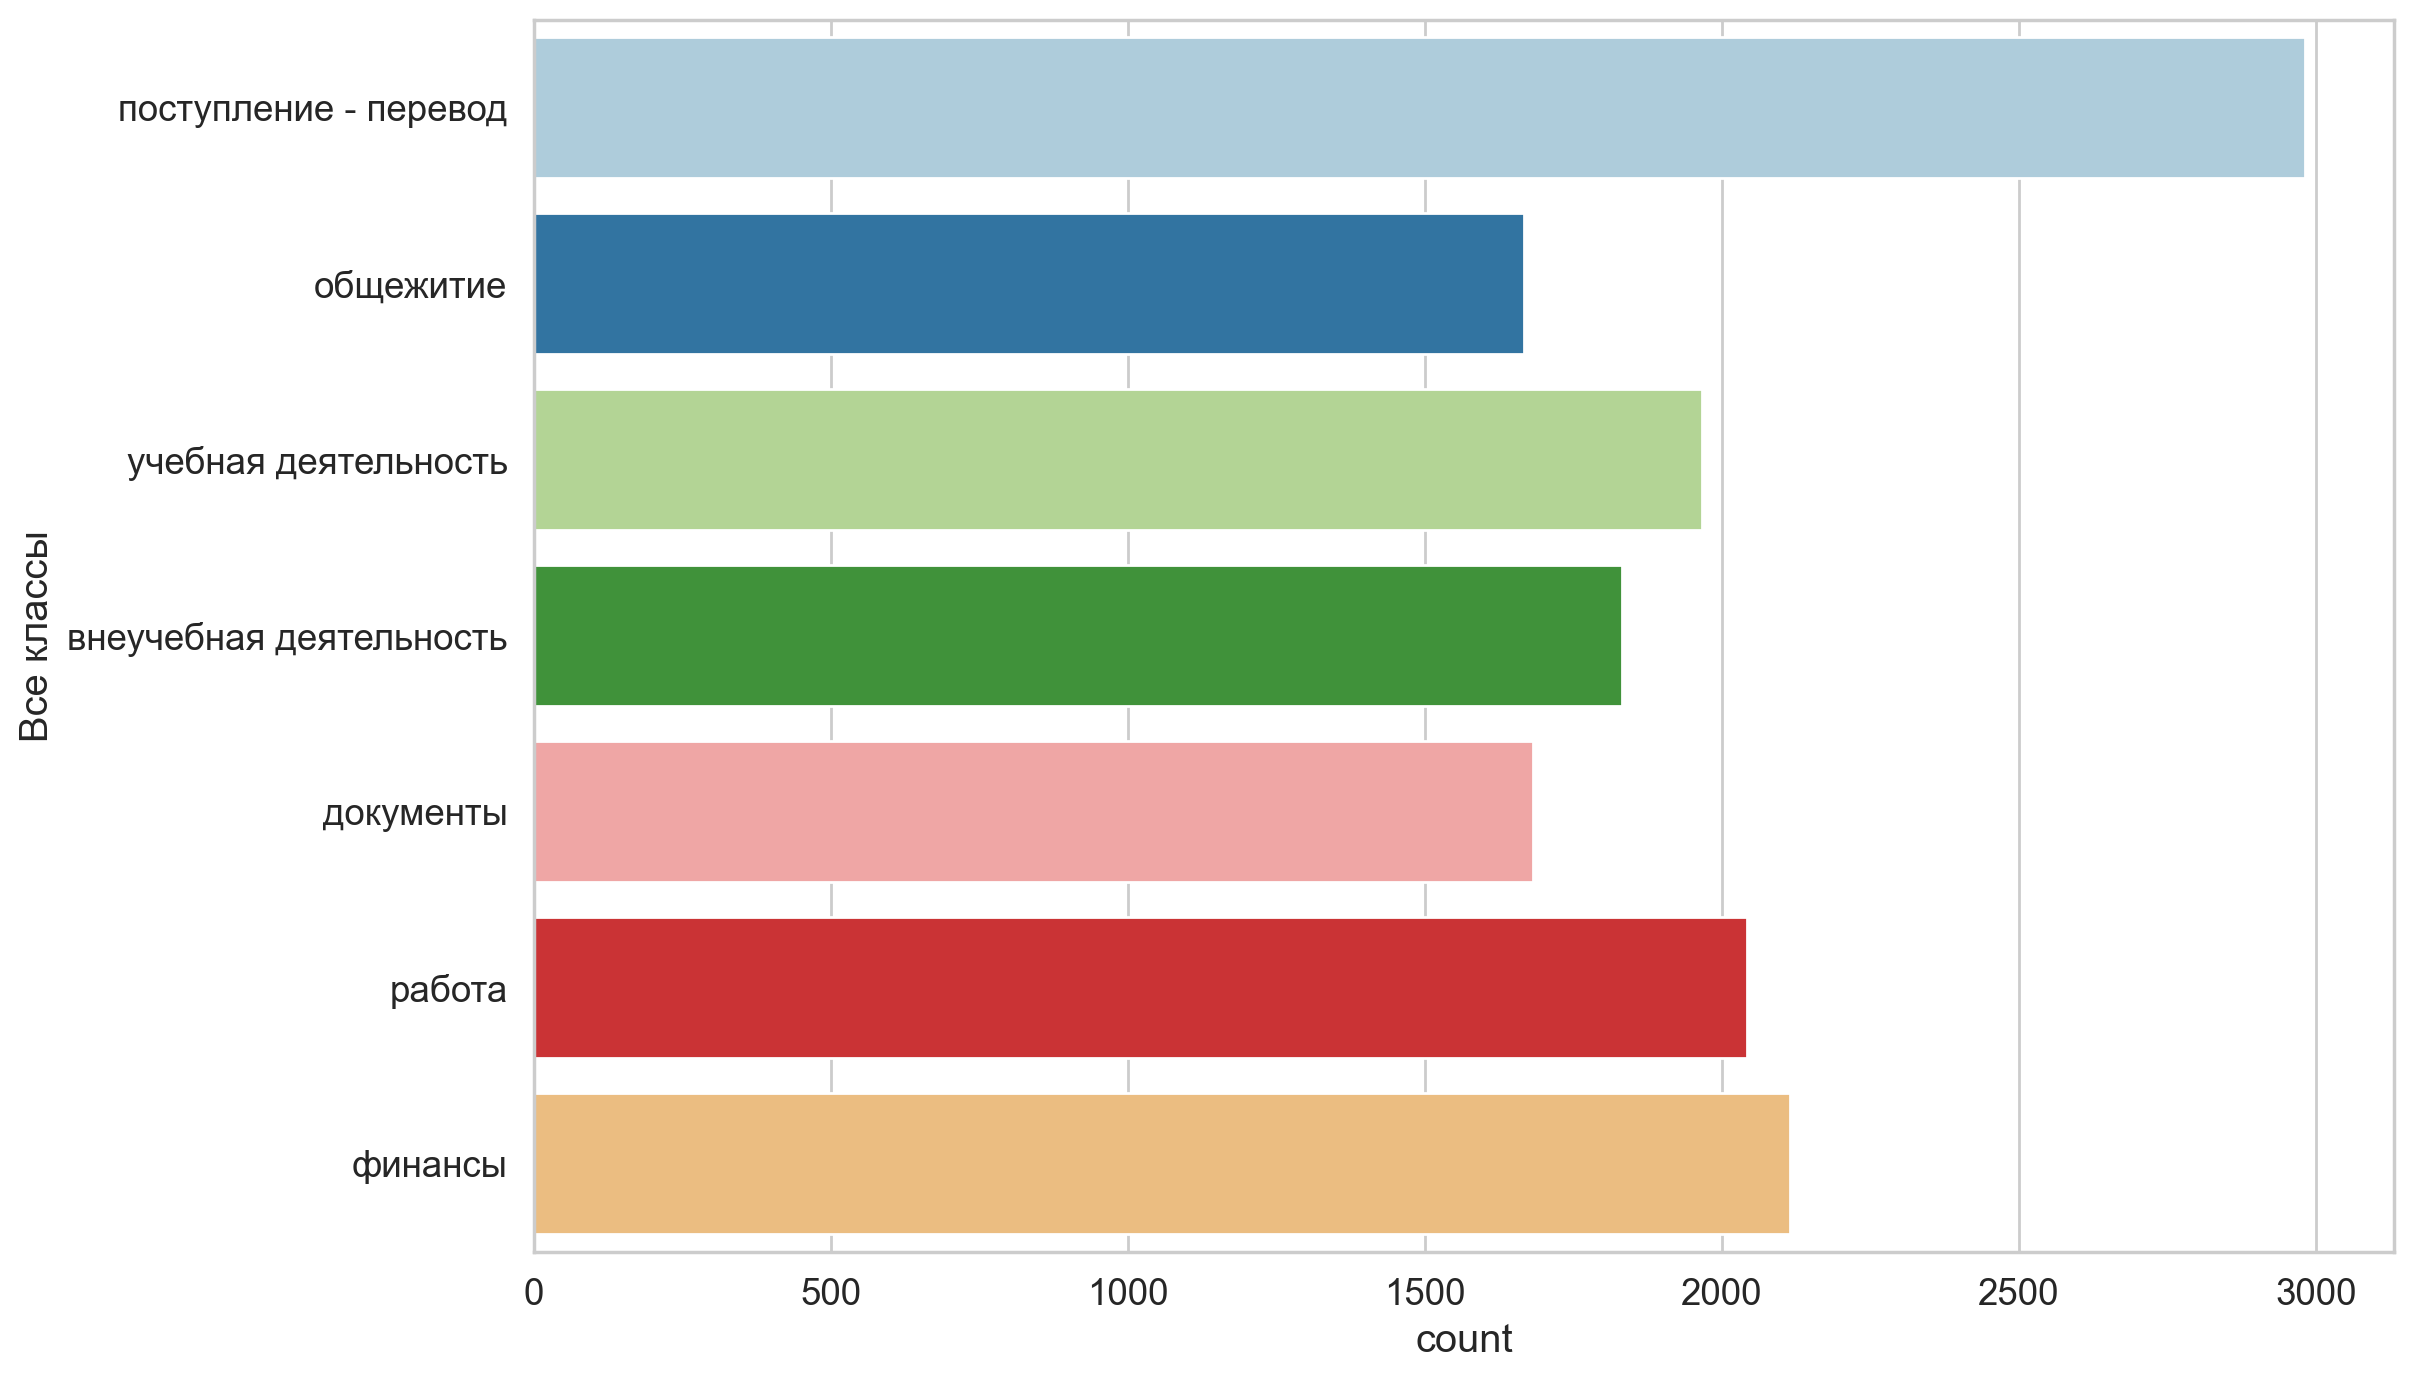

In [10]:
class_names = ['поступление - перевод', 'общежитие', 'учебная деятельность', 'внеучебная деятельность', 'документы', 'работа', 'финансы']

ax = sns.countplot(y = df.label)

plt.ylabel('Все классы')

ax.set_yticklabels(class_names)

# Токенизация и кодирование на образце текста

In [11]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

In [12]:
sample_txt = 'Здравствуйте, подскажите пожалуйста, я обучалась в нгту, кампусная карта уже была, поступила в магистратуру, заполнила данные для кампусной карты, позже увидела, что не надо было заполнять, а можно просто разблокировать в бюро пропусков, мне теперь нужно новую кампусную карту забирать или можно просто разблокировать? То что я ввела данные для кампусной карты, ничего страшного?'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=1000,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt')  # Return PyTorch tensors)

print(f'Encoding keys: {encoding.keys()}')
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

 Sentence: Здравствуйте, подскажите пожалуйста, я обучалась в нгту, кампусная карта уже была, поступила в магистратуру, заполнила данные для кампусной карты, позже увидела, что не надо было заполнять, а можно просто разблокировать в бюро пропусков, мне теперь нужно новую кампусную карту забирать или можно просто разблокировать? То что я ввела данные для кампусной карты, ничего страшного?
   Tokens: ['Здравствуй', '##те', ',', 'подс', '##каж', '##ите', 'пожалуйста', ',', 'я', 'обучалась', 'в', 'нг', '##ту', ',', 'кампус', '##ная', 'карта', 'уже', 'была', ',', 'поступила', 'в', 'магистрат', '##уру', ',', 'заполн', '##ила', 'данные', 'для', 'кампус', '##ной', 'карты', ',', 'позже', 'увидела', ',', 'что', 'не', 'надо', 'было', 'заполня', '##ть', ',', 'а', 'можно', 'просто', 'разблок', '##ировать', 'в', 'бюро', 'пропуск', '##ов', ',', 'мне', 'теперь', 'нужно', 'новую', 'кампус', '##ную', 'карту', 'забирать', 'или', 'можно', 'просто', 'разблок', '##ировать', '?', 'То', 'что', 'я', 'ввела', '

### Количество токенов в вопросах

c:\ProgramData\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Количество токенов')

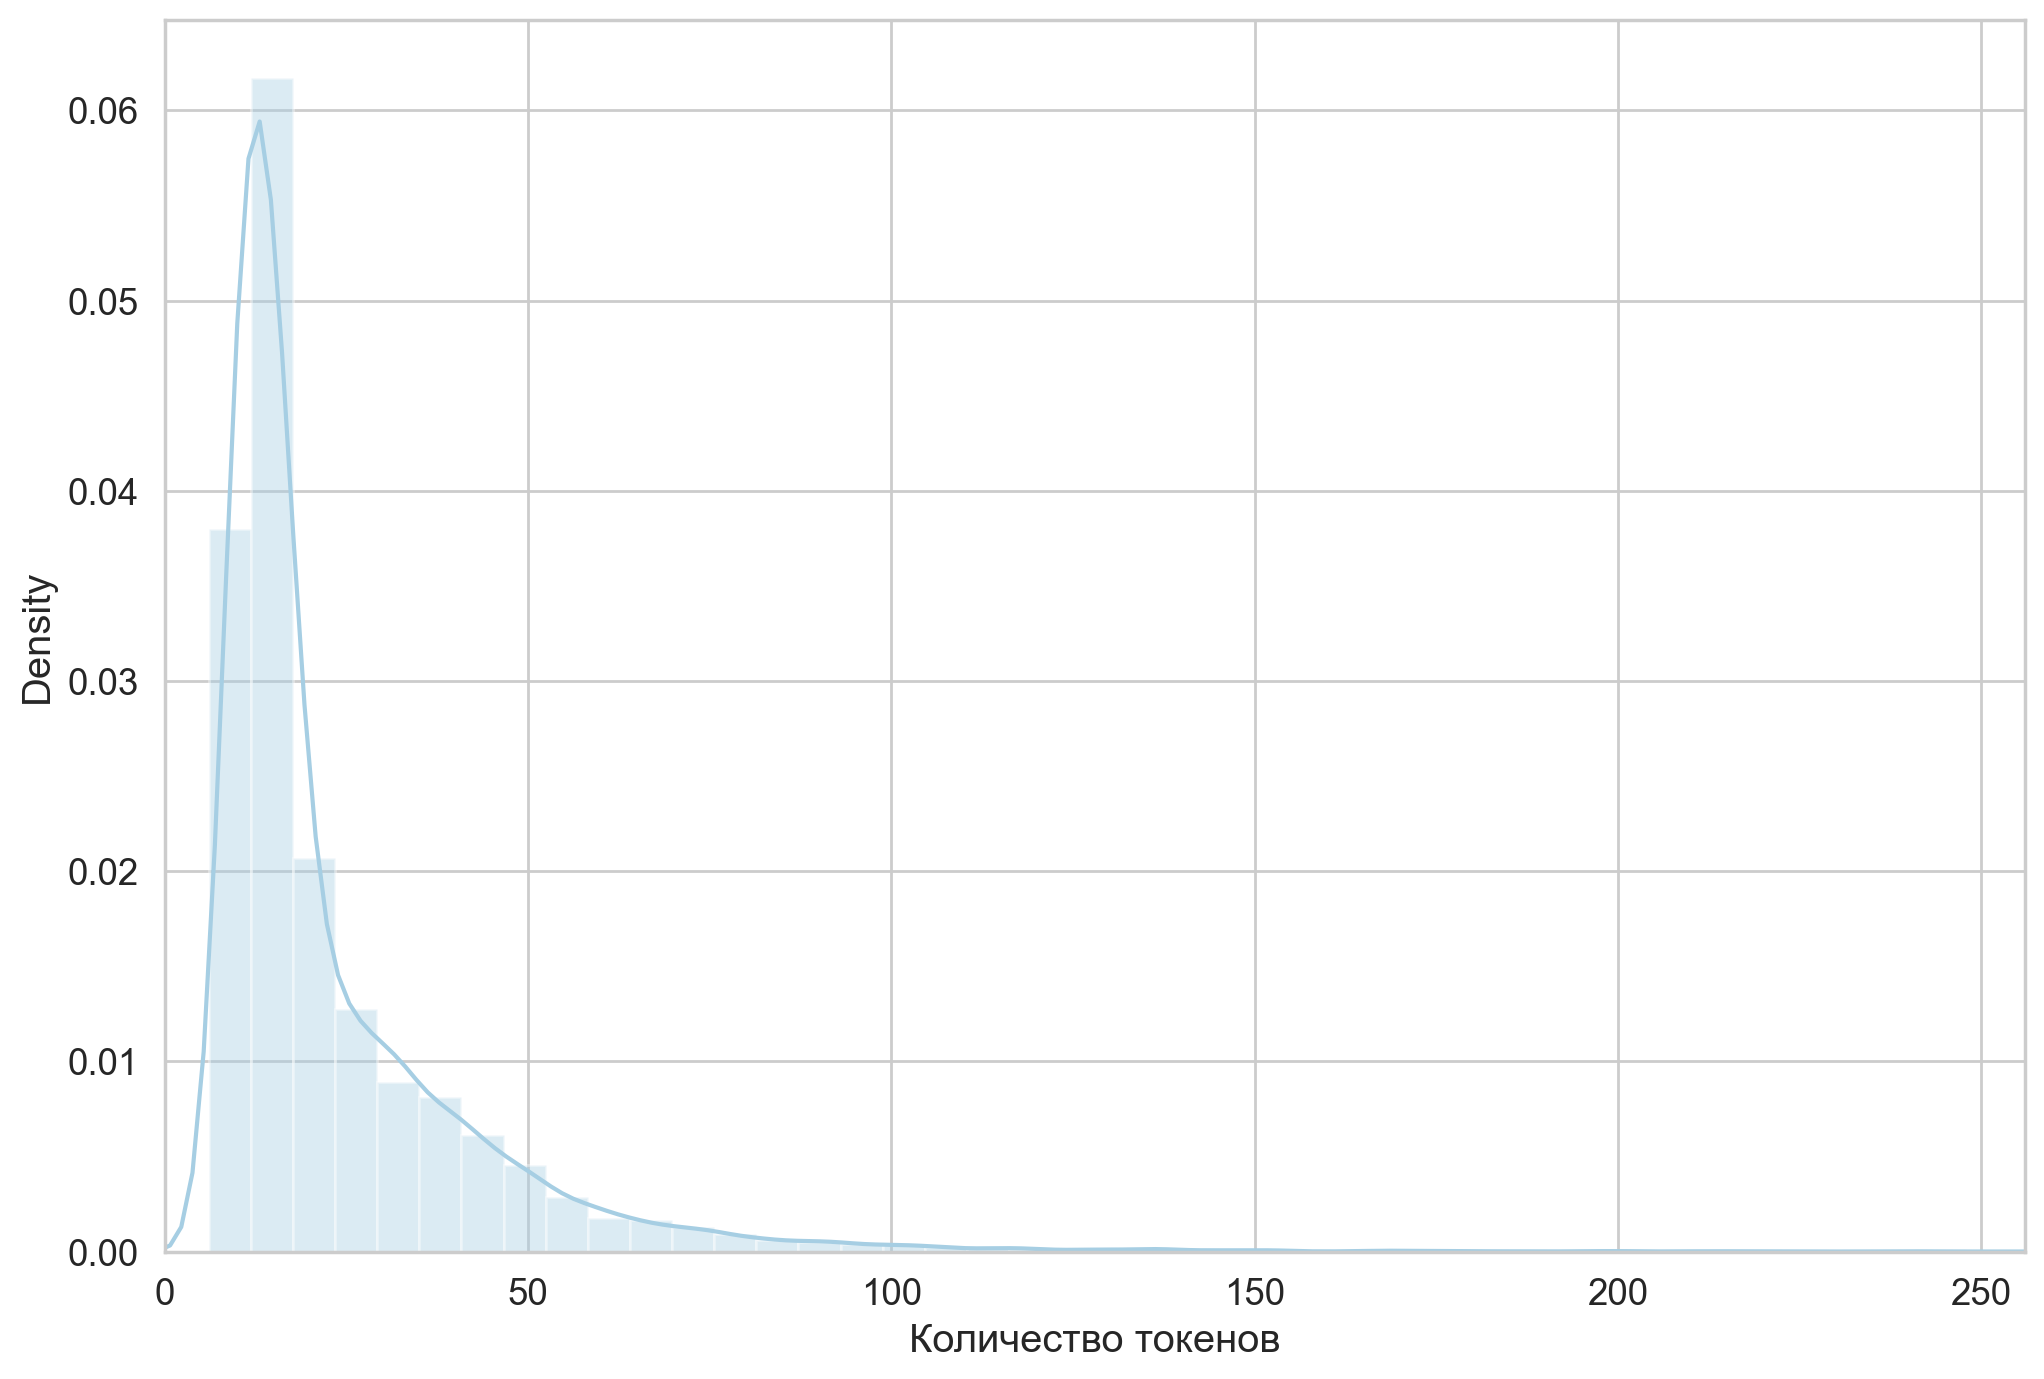

In [13]:
token_lens = []

for txt in df.q:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))


sns.distplot(token_lens)

plt.xlim([0,256])

plt.xlabel('Количество токенов')

# Подготовка датасета

In [14]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(11428, 7) (1428, 7) (1429, 7)


In [15]:
train_data_loader = create_data_loader(df_train, tokenizer, batch_size = 8)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=False)
test_data_loader = create_data_loader(df_test, tokenizer, include_raw_text=False)

In [16]:
for d in val_data_loader:
    print(d.keys())
    
# dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])

dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'att

In [17]:
##Тестируем, чтобы убедиться, что даталоадер работает должным образом
data = next(iter(train_data_loader))

print(data.keys()) # dict_keys(['input_ids', 'attention_mask', 'targets'])

print(data['input_ids'].shape) # torch.Size([16, 512])

print(data['attention_mask'].shape) # torch.Size([16, 512])

print(data['targets'].shape) # torch.Size([16])

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([8, 170])
torch.Size([8, 170])
torch.Size([8])


# Модель

In [18]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

# Just An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.1165, 0.1184, 0.1528, 0.1482, 0.1217, 0.1637, 0.1787],
        [0.1418, 0.1689, 0.1666, 0.1311, 0.1178, 0.1268, 0.1469],
        [0.1267, 0.1263, 0.1688, 0.1407, 0.1477, 0.1393, 0.1504],
        [0.1192, 0.1376, 0.1888, 0.1325, 0.1276, 0.1562, 0.1380],
        [0.1196, 0.1568, 0.1761, 0.1376, 0.1142, 0.1495, 0.1461],
        [0.1060, 0.1541, 0.1780, 0.1324, 0.1399, 0.1523, 0.1372],
        [0.1281, 0.1431, 0.1706, 0.1270, 0.1299, 0.1550, 0.1463],
        [0.1516, 0.1438, 0.1439, 0.1333, 0.1442, 0.1553, 0.1278]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Тренируем

In [19]:
EPOCHS = 2

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 16, 
    num_training_steps=total_steps)

# для мульти классификации
loss_fn = nn.CrossEntropyLoss().to(device)


## Тренировачный цикл

In [20]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'model/best_model_state.bin')
        best_accuracy = val_acc

  

Epoch 1/ 2


loss: 0.16713: 100%|██████████| 1429/1429 [07:58<00:00,  2.99it/s]


Train loss 0.8116936733381805 accuracy 0.735299289226532
Val loss 0.6641546442959062 accuracy 0.7899159789085388
Epoch 2/ 2


loss: 0.09934: 100%|██████████| 1429/1429 [03:37<00:00,  6.56it/s]


Train loss 0.5841424901532419 accuracy 0.8116905689239502
Val loss 0.6560017948959793 accuracy 0.7934173941612244
Wall time: 11min 48s


# Оценка модели на test_data_loader

                         precision    recall  f1-score   support

  поступление - перевод       0.62      0.82      0.70       308
              общежитие       0.90      0.88      0.89       164
   учебная деятельность       0.75      0.68      0.71       192
внеучебная деятельность       0.92      0.75      0.82       193
              документы       0.76      0.61      0.68       188
                 работа       0.99      1.00      1.00       189
                финансы       0.91      0.85      0.88       195

               accuracy                           0.80      1429
              macro avg       0.83      0.80      0.81      1429
           weighted avg       0.82      0.80      0.80      1429



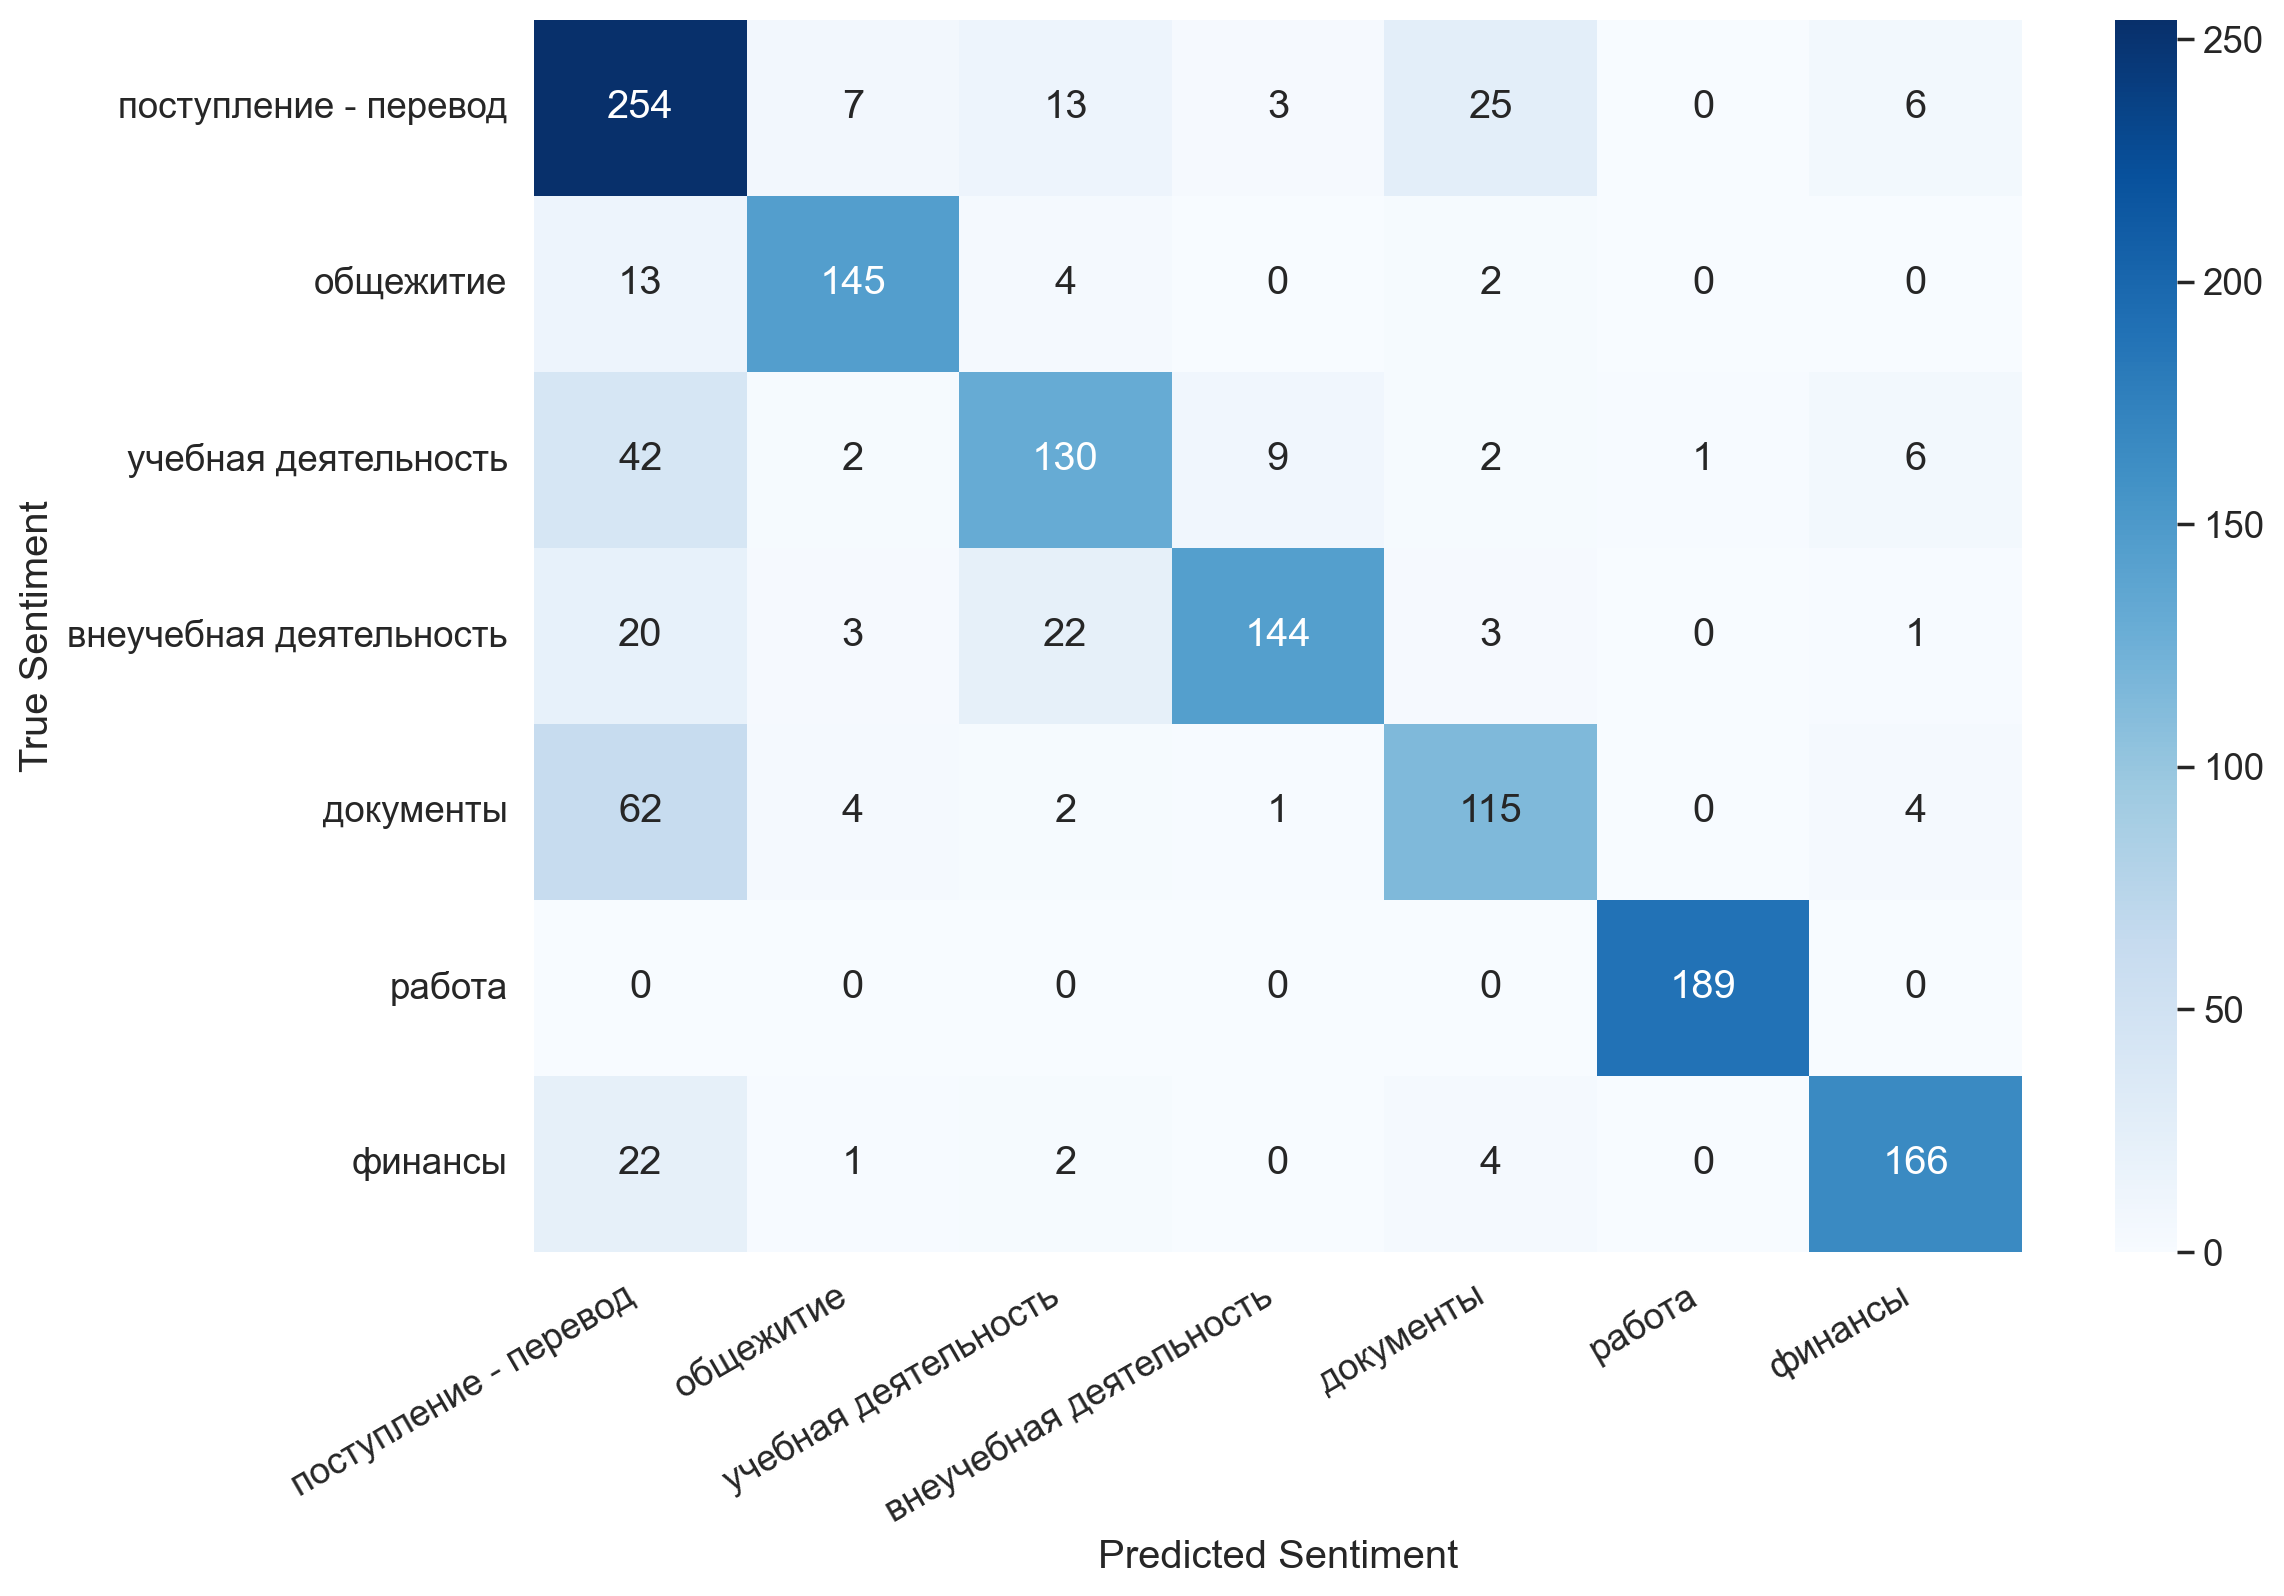

In [21]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

# y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [22]:
review_text = "Что нужно сделать, чтобы поступить на направление?"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')



Review text: Что нужно сделать, чтобы поступить на направление?
Sentiment  : поступление - перевод


c:\ProgramData\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
review_text = "Когда будет сессия?"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Когда будет сессия?
Sentiment  : учебная деятельность
